In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import erf
from tqdm import tqdm
from ipynb.fs.full.Sellke_SIR import SIRSellke_general_pulse
from pickle import load,dump

# Variance investigation

In [65]:
sigma_values = [1,1.5,2,2.5,3]
symp_onset_taus = np.linspace(2,7,21)

In [48]:
params_test = {"mu": 7,"sigma":2}
M1 = np.sqrt(2*np.pi)
test_rescale =  (0.95/norm.pdf(params_test["mu"],params_test["mu"],params_test["sigma"]))/(1-norm.cdf(0,params_test["mu"],params_test["sigma"]))
test_pdf = lambda x : test_rescale*(1/(params_test["sigma"]*M1))*np.exp(-0.5*((x-params_test["mu"])/params_test["sigma"])**2)

In [66]:
symp_onset_taus

array([2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 ,
       4.75, 5.  , 5.25, 5.5 , 5.75, 6.  , 6.25, 6.5 , 6.75, 7.  ])

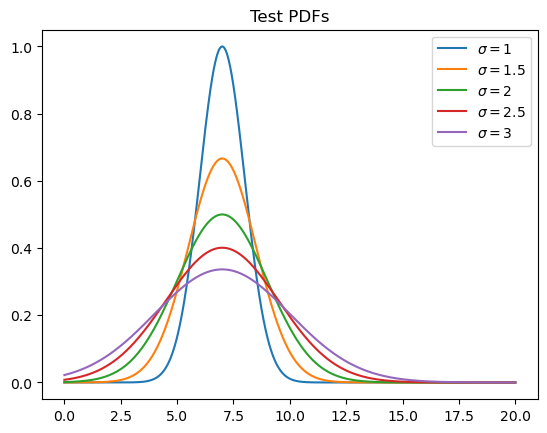

In [26]:
X = np.linspace(0,20,2001)
s = 1
base_rescale =  1/(norm.pdf(params_test["mu"],params_test["mu"],s)*(1-norm.cdf(0,params_test["mu"],s)))

for s in sigma_values:    
    params_test = {"mu": 7,"sigma":s}
    M1 = np.sqrt(2*np.pi)
    test_rescale =  base_rescale/(1-norm.cdf(0,params_test["mu"],params_test["sigma"]))
    test_pdf = lambda x : test_rescale*(1/(params_test["sigma"]*M1))*np.exp(-0.5*((x-params_test["mu"])/params_test["sigma"])**2)
    Y = [test_pdf(x) for x in X]
    plt.plot(X,Y, label = r'$\sigma =$' + str(s)  )
plt.title("Test PDFs")
plt.legend()

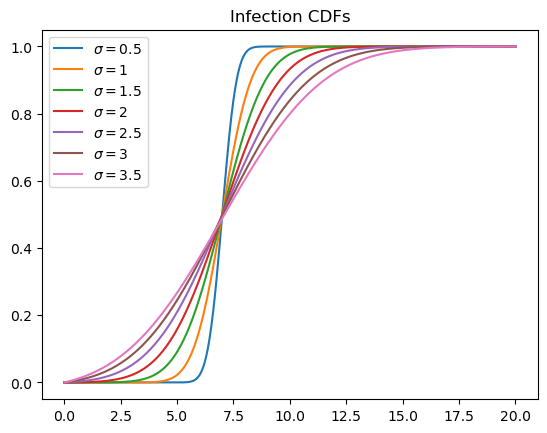

In [53]:
for s in sigma_values:    
    params_inf = {"mu": 7,"sigma":s}
    M2 = params_inf["sigma"]*np.sqrt(2)
    inf_rescale = 1/(1-norm.cdf(0,params_inf["mu"],params_inf["sigma"]))
    inf_cdf = lambda T1,T2: inf_rescale* (0.5*(1+erf((T2-params_inf["mu"])/M2)) - 0.5*(1+erf((T1-params_inf["mu"])/M2))) if (T1>=0 and T2>T1) else 0
    Y = [inf_cdf(0,x) for x in X]
    plt.plot(X,Y, label = r'$\sigma =$' + str(s)  )
plt.title("Infection CDFs")
plt.legend()


# 

In [73]:
Q_gens = []
P_gens = []
n=50
m=1
for i in tqdm(range(5000)):
    P = np.random.uniform(0,1,n+m)
    Q_unsorted = np.random.exponential(1,n)
    Q = np.sort(Q_unsorted)
    Q_gens.append(Q)
    P_gens.append(P)

100%|██████████| 5000/5000 [00:00<00:00, 89441.47it/s]


In [75]:
sigma_values = [1,1.5,2,2.5,3]
symp_thresholds = np.linspace(1,10,10)
symp_onset_taus = np.linspace(2,7,21)
R0 = 1.5
n=50
m=1
params_test = {"mu": 7,"sigma":2}
M1 = np.sqrt(2*np.pi)
test_rescale =  (0.95/norm.pdf(params_test["mu"],params_test["mu"],params_test["sigma"]))/(1-norm.cdf(0,params_test["mu"],params_test["sigma"]))
test_pdf = lambda x : test_rescale*(1/(params_test["sigma"]*M1))*np.exp(-0.5*((x-params_test["mu"])/params_test["sigma"])**2)

for s in tqdm(sigma_values):
    params_inf = {"mu": 7,"sigma":s}
    M2 = params_inf["sigma"]*np.sqrt(2)
    inf_rescale = 1/(1-norm.cdf(0,params_inf["mu"],params_inf["sigma"]))
    inf_cdf = lambda T1,T2: inf_rescale* (0.5*(1+erf((T2-params_inf["mu"])/M2)) - 0.5*(1+erf((T1-params_inf["mu"])/M2))) if (T1>=0 and T2>T1) else 0
    for thresh in tqdm(symp_thresholds):
        for t in tqdm(symp_onset_taus):
            final_sizes = []
            N_det = []
            spread_measures = []
            symp_tau = [t]*(n+m)

            for i in range(5000):
                Q = Q_gens[i]
                P = P_gens[i]
                r = SIRSellke_general_pulse(n,m,Q,P,inf_cdf,R0,symp_tau,test_pdf,thresh,1)
                final_sizes.append(r[4])

                N_det.append(r[7])
                x = np.diff(r[3])[:r[4]-1]

                x.sort()
                if r[4]>2:
                    meas = np.percentile(np.diff(x),50)
                else:
                    meas = np.inf
                spread_measures.append(meas)


            filename1 = "outputs//final_sizes_sig="+str(s)+"_onset="+str(t)+ "_threshold="+str(thresh)+".pkl"
            with open((filename1), 'wb') as f:
                    dump(final_sizes,f)

            filename2 = "outputs//N_det_sig="+str(s)+"_onset="+str(t)+ "_threshold="+str(thresh)+".pkl"
            with open((filename2), 'wb') as f:
                    dump(N_det,f)

            filename3 = "outputs//spread_measures_sig="+str(s)+"_onset="+str(t)+ "_threshold="+str(thresh)+".pkl"
            with open((filename3), 'wb') as f:
                    dump(spread_measures,f)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|▍         | 1/21 [00:56<18:43, 56.17s/it]

 10%|▉         | 2/21 [01:49<17:18, 54.65s/it]

 14%|█▍        | 3/21 [02:41<15:57, 53.20s/it]

 19%|█▉        | 4/21 [03:48<16:42, 58.94s/it]

 24%|██▍       | 5/21 [04:54<16:23, 61.46s/it]

 29%|██▊       | 6/21 [05:47<14:35, 58.39s/it]

 33%|███▎      | 7/21 [06:34<12:47, 54.81s/it]

 38%|███▊      | 8/21 [07:19<11:12, 51.71s/it]

 43%|████▎     | 9/21 [07:57<09:26, 47.23s/it]

 48%|████▊     | 10/21 [08:27<07:42, 42.04s/it]

 52%|█████▏    | 11/21 [08:57<06:23, 38.30s/it]

 57%|█████▋    | 12/21 [09:27<05:21, 35.70s/it]

 62%|██████▏   | 13/21 [09:55<04:27, 33.42s/it]

 67%|██████▋   | 14/21 [10:24<03:44, 32.01s/it]

 71%|███████▏  | 15/21 [10:58<03:15, 32.63s/it]

 76%|███████▌  | 16/21 [11:41<02:59, 35.86s/it]

 81%|████████  | 17/21 [12:32<02:40, 40.24s/it]

 86%|████████▌ | 18/21 [13:32<02:18, 46.31s/it]

 90%|█████████ | 19/21 [14:35<01:42, 51.38s/it]

# Threshold of 3 and non random symptom onset.

In [8]:
symp_onset_taus = np.linspace(2,12,41)
R0 = 1.5
symp_thresh = 3

for s in tqdm(sigma_values):
    print(r'sigma = ' + str(s))
    params_test = {"mu": 7,"sigma":s*1.1}
    M1 = np.sqrt(2*np.pi)
    test_rescale =  (0.95)/(norm.pdf(params_test["mu"],params_test["mu"],params_test["sigma"])*(1-norm.cdf(0,params_test["mu"],params_test["sigma"])))
    test_pdf = lambda x : test_rescale*(1/(params_test["sigma"]*M1))*np.exp(-0.5*((x-params_test["mu"])/params_test["sigma"])**2)
    
    params_inf = {"mu": 7,"sigma":s}
    M2 = params_inf["sigma"]*np.sqrt(2)
    inf_rescale = 1/(1-norm.cdf(0,params_inf["mu"],params_inf["sigma"]))
    inf_cdf = lambda T1,T2: inf_rescale* (0.5*(1+erf((T2-params_inf["mu"])/M2)) - 0.5*(1+erf((T1-params_inf["mu"])/M2))) if (T1>=0 and T2>T1) else 0
    
    for t in symp_onset_taus:
        final_sizes = []
        N_det = []
        spread_measures = []
        print('   t = ' + str(t))
        symp_tau = [t]*(n+m)
        
        for i in range(10000):
            Q = Q_gens[i]
            P = P_gens[i]
            r = SIRSellke_general_pulse(n,m,Q,P,inf_cdf,R0,symp_tau,test_pdf,symp_thresh,1)
            final_sizes.append(r[4])
            
            N_det.append(r[7])
            x = np.diff(r[3])[:r[4]-1]
            
            x.sort()
            if r[4]>2:
                meas = np.percentile(np.diff(x),50)
            else:
                meas = np.inf
            spread_measures.append(meas)
            
            
        filename1 = "variance_inv_results//final_sizes_sig="+str(s)+"_onset="+str(t)+".pkl"
        with open((filename1), 'wb') as f:
                dump(final_sizes,f)
                
        filename2 = "variance_inv_results//N_det_sig="+str(s)+"_onset="+str(t)+".pkl"
        with open((filename2), 'wb') as f:
                dump(N_det,f)
        
        filename3 = "variance_inv_results//spread_measures_sig="+str(s)+"_onset="+str(t)+".pkl"
        with open((filename3), 'wb') as f:
                dump(spread_measures,f)


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

sigma = 0.5
   t = 2.0
   t = 2.25
   t = 2.5
   t = 2.75
   t = 3.0
   t = 3.25
   t = 3.5
   t = 3.75
   t = 4.0
   t = 4.25
   t = 4.5
   t = 4.75
   t = 5.0
   t = 5.25
   t = 5.5
   t = 5.75
   t = 6.0
   t = 6.25
   t = 6.5
   t = 6.75
   t = 7.0
   t = 7.25
   t = 7.5
   t = 7.75
   t = 8.0
   t = 8.25
   t = 8.5
   t = 8.75
   t = 9.0
   t = 9.25
   t = 9.5
   t = 9.75
   t = 10.0
   t = 10.25
   t = 10.5
   t = 10.75
   t = 11.0
   t = 11.25
   t = 11.5
   t = 11.75
   t = 12.0


 20%|███████████████▌                                                              | 1/5 [1:21:35<5:26:22, 4895.68s/it]

sigma = 1
   t = 2.0
   t = 2.25
   t = 2.5
   t = 2.75
   t = 3.0
   t = 3.25
   t = 3.5
   t = 3.75
   t = 4.0
   t = 4.25
   t = 4.5
   t = 4.75
   t = 5.0
   t = 5.25
   t = 5.5
   t = 5.75
   t = 6.0
   t = 6.25
   t = 6.5
   t = 6.75
   t = 7.0
   t = 7.25
   t = 7.5
   t = 7.75
   t = 8.0
   t = 8.25
   t = 8.5
   t = 8.75
   t = 9.0
   t = 9.25
   t = 9.5
   t = 9.75
   t = 10.0
   t = 10.25
   t = 10.5
   t = 10.75
   t = 11.0
   t = 11.25
   t = 11.5
   t = 11.75
   t = 12.0


 40%|███████████████████████████████▏                                              | 2/5 [2:32:47<3:46:25, 4528.47s/it]

sigma = 1.5
   t = 2.0
   t = 2.25
   t = 2.5
   t = 2.75
   t = 3.0
   t = 3.25
   t = 3.5
   t = 3.75
   t = 4.0
   t = 4.25
   t = 4.5
   t = 4.75
   t = 5.0
   t = 5.25
   t = 5.5
   t = 5.75
   t = 6.0
   t = 6.25
   t = 6.5
   t = 6.75
   t = 7.0
   t = 7.25
   t = 7.5
   t = 7.75
   t = 8.0
   t = 8.25
   t = 8.5
   t = 8.75
   t = 9.0
   t = 9.25
   t = 9.5
   t = 9.75
   t = 10.0
   t = 10.25
   t = 10.5
   t = 10.75
   t = 11.0
   t = 11.25
   t = 11.5
   t = 11.75
   t = 12.0


 60%|██████████████████████████████████████████████▊                               | 3/5 [3:37:18<2:20:56, 4228.41s/it]

sigma = 2
   t = 2.0
   t = 2.25
   t = 2.5
   t = 2.75
   t = 3.0
   t = 3.25
   t = 3.5
   t = 3.75
   t = 4.0
   t = 4.25
   t = 4.5
   t = 4.75
   t = 5.0
   t = 5.25
   t = 5.5
   t = 5.75
   t = 6.0
   t = 6.25
   t = 6.5
   t = 6.75
   t = 7.0
   t = 7.25
   t = 7.5
   t = 7.75
   t = 8.0
   t = 8.25
   t = 8.5
   t = 8.75
   t = 9.0
   t = 9.25
   t = 9.5
   t = 9.75
   t = 10.0
   t = 10.25
   t = 10.5
   t = 10.75
   t = 11.0
   t = 11.25
   t = 11.5
   t = 11.75
   t = 12.0


 80%|██████████████████████████████████████████████████████████████▍               | 4/5 [4:37:44<1:06:30, 3990.68s/it]

sigma = 2.5
   t = 2.0
   t = 2.25
   t = 2.5
   t = 2.75
   t = 3.0
   t = 3.25
   t = 3.5
   t = 3.75
   t = 4.0
   t = 4.25
   t = 4.5
   t = 4.75
   t = 5.0
   t = 5.25
   t = 5.5
   t = 5.75
   t = 6.0
   t = 6.25
   t = 6.5
   t = 6.75
   t = 7.0
   t = 7.25
   t = 7.5
   t = 7.75
   t = 8.0
   t = 8.25
   t = 8.5
   t = 8.75
   t = 9.0
   t = 9.25
   t = 9.5
   t = 9.75
   t = 10.0
   t = 10.25
   t = 10.5
   t = 10.75
   t = 11.0
   t = 11.25
   t = 11.5
   t = 11.75
   t = 12.0


100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [5:34:54<00:00, 4018.99s/it]


# Varied threshold with symptoms at 7 days

In [7]:
symp_thresh = np.linspace(1,15,15)
R0 = 1.5

for s in tqdm(sigma_values):
    print(r'sigma = ' + str(s))
    params_test = {"mu": 7,"sigma":s*1.1}
    M1 = np.sqrt(2*np.pi)
    test_rescale =  (0.95)/(norm.pdf(params_test["mu"],params_test["mu"],params_test["sigma"])*(1-norm.cdf(0,params_test["mu"],params_test["sigma"])))
    test_pdf = lambda x : test_rescale*(1/(params_test["sigma"]*M1))*np.exp(-0.5*((x-params_test["mu"])/params_test["sigma"])**2)
    
    params_inf = {"mu": 7,"sigma":s}
    M2 = params_inf["sigma"]*np.sqrt(2)
    inf_rescale = 1/(1-norm.cdf(0,params_inf["mu"],params_inf["sigma"]))
    inf_cdf = lambda T1,T2: inf_rescale* (0.5*(1+erf((T2-params_inf["mu"])/M2)) - 0.5*(1+erf((T1-params_inf["mu"])/M2))) if (T1>=0 and T2>T1) else 0
    
    for t in symp_thresh:
        final_sizes = []
        N_det = []
        spread_measures = []
        print('   t = ' + str(t))
        symp_tau = [7]*(n+m)
        
        for i in range(10000):
            Q = Q_gens[i]
            P = P_gens[i]
            r = SIRSellke_general_pulse(n,m,Q,P,inf_cdf,R0,symp_tau,test_pdf,t,1)
            final_sizes.append(r[4])
            
            N_det.append(r[7])
            x = np.diff(r[3])[:r[4]-1]
            
            x.sort()
            if r[4]>2:
                meas = np.percentile(np.diff(x),50)
            else:
                meas = np.inf
            spread_measures.append(meas)
            
            
        filename1 = "variance_inv_results//final_sizes_sig="+str(s)+"_threshold="+str(t)+".pkl"
        with open((filename1), 'wb') as f:
                dump(final_sizes,f)
            
        filename2 = "variance_inv_results//N_det_sig="+str(s)+"_threshold="+str(t)+".pkl"
        with open((filename2), 'wb') as f:
                dump(N_det,f)
        
        filename3 = "variance_inv_results//spread_measures_sig="+str(s)+"_threshold="+str(t)+".pkl"
        with open((filename3), 'wb') as f:
                dump(spread_measures,f)


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

sigma = 0.5
   t = 1.0
   t = 2.0
   t = 3.0
   t = 4.0
   t = 5.0
   t = 6.0
   t = 7.0
   t = 8.0
   t = 9.0
   t = 10.0
   t = 11.0
   t = 12.0
   t = 13.0
   t = 14.0
   t = 15.0


 20%|████████████████                                                                | 1/5 [29:44<1:58:56, 1784.24s/it]

sigma = 1
   t = 1.0
   t = 2.0
   t = 3.0
   t = 4.0
   t = 5.0
   t = 6.0
   t = 7.0
   t = 8.0
   t = 9.0
   t = 10.0
   t = 11.0
   t = 12.0
   t = 13.0
   t = 14.0
   t = 15.0


 40%|████████████████████████████████                                                | 2/5 [56:43<1:24:22, 1687.44s/it]

sigma = 1.5
   t = 1.0
   t = 2.0
   t = 3.0
   t = 4.0
   t = 5.0
   t = 6.0
   t = 7.0
   t = 8.0
   t = 9.0
   t = 10.0
   t = 11.0
   t = 12.0
   t = 13.0
   t = 14.0
   t = 15.0


 60%|████████████████████████████████████████████████                                | 3/5 [1:22:37<54:12, 1626.42s/it]

sigma = 2
   t = 1.0
   t = 2.0
   t = 3.0
   t = 4.0
   t = 5.0
   t = 6.0
   t = 7.0
   t = 8.0
   t = 9.0
   t = 10.0
   t = 11.0
   t = 12.0
   t = 13.0
   t = 14.0
   t = 15.0


 80%|████████████████████████████████████████████████████████████████                | 4/5 [1:45:50<25:34, 1534.02s/it]

sigma = 2.5
   t = 1.0
   t = 2.0
   t = 3.0
   t = 4.0
   t = 5.0
   t = 6.0
   t = 7.0
   t = 8.0
   t = 9.0
   t = 10.0
   t = 11.0
   t = 12.0
   t = 13.0
   t = 14.0
   t = 15.0


100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [2:07:35<00:00, 1531.00s/it]


# Final size

[17.8657, 17.8657, 17.8655, 17.8614, 17.8539, 17.8439, 17.8136, 17.7752, 17.7107, 17.5884, 17.2606, 16.7825, 16.1654, 15.5271, 15.1273, 15.1885, 15.7893, 16.6007, 17.1584, 17.5431, 17.6702, 17.7483, 17.8053, 17.8316, 17.855, 17.8592, 17.8627, 17.8657, 17.8657, 17.8657, 17.8607, 17.8535, 17.8428, 17.8142, 17.7805, 17.72, 17.5677, 17.3969, 17.1307, 16.8026, 16.484]
[17.6891, 17.6236, 17.5826, 17.4419, 17.2601, 17.0332, 16.7826, 16.4898, 16.1682, 15.9078, 15.5271, 15.2952, 15.1273, 15.082, 15.1885, 15.436, 15.7892, 16.1896, 16.6004, 16.9382, 17.1548, 17.383, 17.5087, 17.5796, 17.5995, 17.6065, 17.6138, 17.5809, 17.5265, 17.4498, 17.3717, 17.2617, 17.1334, 16.9784, 16.8043, 16.6092, 16.4827, 16.3682, 16.2897, 16.2311, 16.1798]
[16.8981, 16.7602, 16.5992, 16.4341, 16.2203, 16.0737, 15.8354, 15.5706, 15.4164, 15.2598, 15.1481, 15.1061, 15.0946, 15.1687, 15.3173, 15.5025, 15.7325, 15.9963, 16.2216, 16.463, 16.675, 16.8204, 16.9043, 17.0023, 17.0801, 17.0809, 17.0286, 16.9842, 16.9026, 16.7858

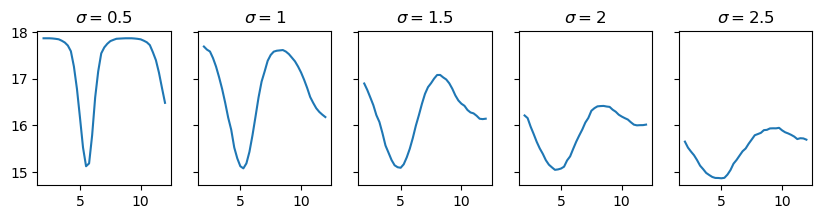

In [9]:
fig, axs = plt.subplots(1,len(sigma_values), figsize=(10,2),sharey=True)

for i,s in enumerate(sigma_values):
    final_size_means = []
    for t in symp_onset_taus:
        filename = "variance_inv_results//final_sizes_sig="+str(s)+"_onset="+str(t)+".pkl"
        with open((filename), 'rb') as f:
                final_sizes = load(f)
        final_size_means.append(np.mean(final_sizes))
    print(final_size_means)
    axs[i].plot(symp_onset_taus,final_size_means)
    axs[i].set_title(r'$\sigma =$' + str(s))

# Number of detected

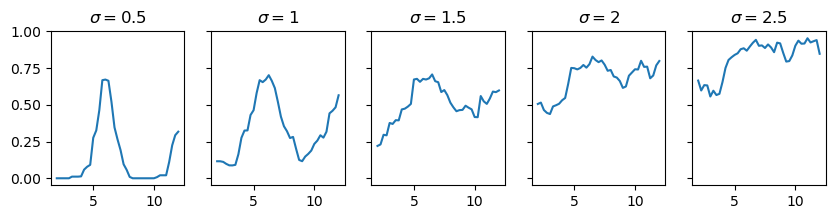

In [19]:
fig, axs = plt.subplots(1,len(sigma_values), figsize=(10,2),sharey=True)

for i,s in enumerate(sigma_values):
    N_det_means = []
    for t in symp_onset_taus:
        filename = "variance_inv_results//final_sizes_sig="+str(s)+"_onset="+str(t)+".pkl"
        with open((filename), 'rb') as f:
                final_sizes = load(f)
                
                
        filename = "variance_inv_results//N_det_sig="+str(s)+"_onset="+str(t)+".pkl"
        with open((filename), 'rb') as f:
                N_det = load(f)
        N_det_means.append(np.mean([N_det[i] for x,i in enumerate(final_sizes) if x>5]))
    axs[i].plot(symp_onset_taus,N_det_means)
    axs[i].set_title(r'$\sigma =$' + str(s))

# Final Size

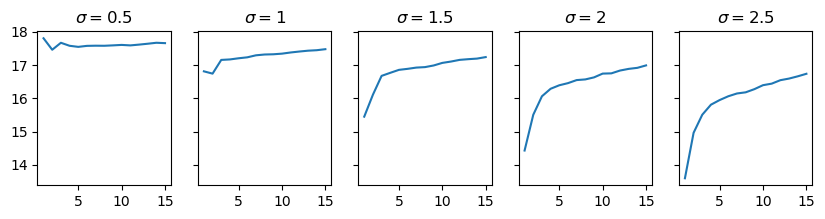

In [16]:
fig, axs = plt.subplots(1,len(sigma_values), figsize=(10,2),sharey=True)
symp_thresh = np.linspace(1,15,15)
for i,s in enumerate(sigma_values):
    final_size_means = []
    for t in symp_thresh:
        filename = "variance_inv_results//final_sizes_sig="+str(s)+"_threshold="+str(t)+".pkl"
        with open((filename), 'rb') as f:
                final_sizes = load(f)
        final_size_means.append(np.mean(final_sizes))
    axs[i].plot(symp_thresh,final_size_means)
    axs[i].set_title(r'$\sigma =$' + str(s))

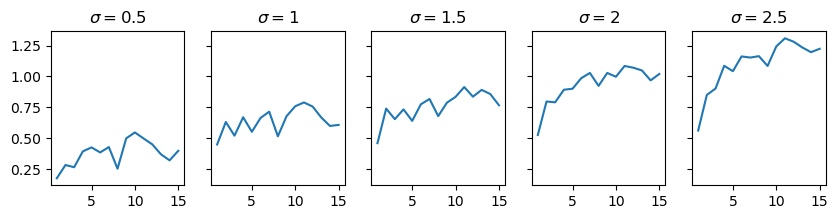

In [21]:
fig, axs = plt.subplots(1,len(sigma_values), figsize=(10,2),sharey=True)

for i,s in enumerate(sigma_values):
    N_det_means = []
    for t in symp_thresh:
        filename = "variance_inv_results//final_sizes_sig="+str(s)+"_threshold="+str(t)+".pkl"
        with open((filename), 'rb') as f:
                final_sizes = load(f)
                
                
        filename = "variance_inv_results//N_det_sig="+str(s)+"_threshold="+str(t)+".pkl"
        with open((filename), 'rb') as f:
                N_det = load(f)
        N_det_means.append(np.mean([N_det[i] for x,i in enumerate(final_sizes) if x>5]))
    axs[i].plot(symp_thresh,N_det_means)
    axs[i].set_title(r'$\sigma =$' + str(s))